![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1277]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from itertools import combinations
from scipy.stats import ttest_ind
from scipy import stats

from datetime import datetime
from datetime import date

import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [1278]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [1279]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [1280]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [1281]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [1282]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [1283]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [1284]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [1285]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [1286]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [1287]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [1288]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [1289]:
data.columns = ['Restaurant_id', 'City', 'Cuisine_style', 'Ranking', 'Price_range',
       'Reviews_number', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating']

In [1290]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data

## 1. Обработка NAN 

Проверим на наличие пропусков. Вынесем информацию о наличие пропусков отдельным признаком по каждому столбцу.
Заполнять пустые значения по каждому признаку будем в самом конце - станет более понятно, как заполнять и нужен ли нам этот признак вообще

,Total missing values,Percent
Price_range,17361,34.72
Cuisine_style,11590,23.18
Reviews_number,3200,6.40
Reviews,2,0.00
Rating,0,0.00
sample,0,0.00
ID_TA,0,0.00
URL_TA,0,0.00
Ranking,0,0.00
City,0,0.00


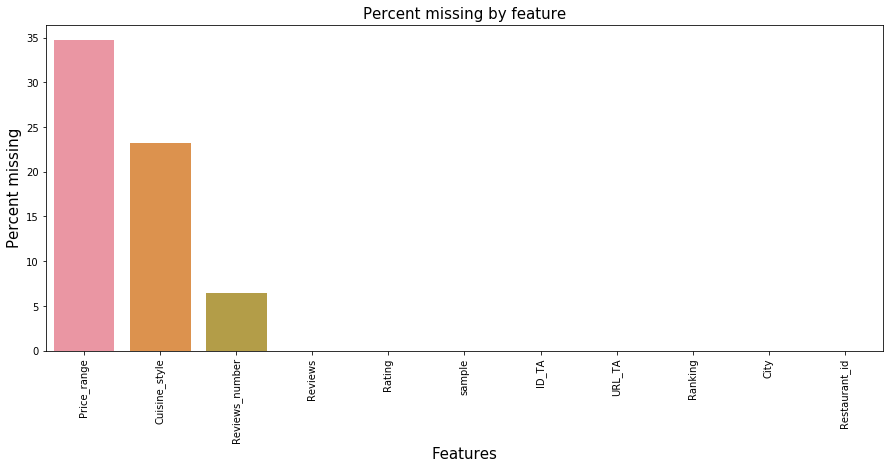

In [1291]:
def na_checks(dataset):
    """Функция для визуализации пропусков в датасете"""
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = round((dataset.isnull().sum()/dataset.isnull().count()
                     ).sort_values(ascending=False)*100, 2)
    missing_data = pd.concat([total, percent], axis=1, keys=[
                             'Total missing values', 'Percent'])
    f, ax = plt.subplots(figsize=(15, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=missing_data.index, y=missing_data['Percent'])
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent missing', fontsize=15)
    plt.title('Percent missing by feature', fontsize=15)
    return missing_data

na_checks(data)


In [1292]:
# Признаки по наличию пропусков
missing_values = ['Price_range', 'Cuisine_style', 'Reviews_number', 'Reviews']

for column in missing_values:
    data[column+"_isNAN"] = pd.isna(data[column]).astype('uint8')

## 2. Обработка признаков

Разберемся пока с признаками, требующими очистки / преобразования для дальнейшей работы

**Cuisine Style**

Данные типа object, которые хорошо было бы преобразовать в список кухонь для создания новых признаков на основе существующего

In [1293]:
def convert(x):
#Функция для очистки Cuisine Style
    if type(x) == int:
        res = []
        return res
    else:
        pattern = re.compile('[a-zA-Z ]{2,}')
        x = pattern.findall(x)
        return x
    
    
data['Cuisine_style'] = data['Cuisine_style'].fillna(0)
data['Cuisine_style'] = data['Cuisine_style'].apply(lambda x: convert(x))

**Reviews**

In [1294]:
data['Reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Похожая история, как и с Cuisine Style. Данные типа object, которые хорошо было бы разбить на два признака: список с отзывами и список с датами этих отзывов:

In [1295]:
#функция для получения списка дат
def extract_dates(x):
    pattern = re.compile('\d{2}/\d{2}/\d{4}')
    return pattern.findall(str(x))


data['Reviews'] = data['Reviews'].fillna(0)
data['Review_dates'] = data['Reviews'].apply(lambda x: extract_dates(x))

# Сразу выведем к-во дат = к-во отзывов, так как было замечено, что иногда отзыв только один:
data['Dates_count'] = data['Review_dates'].apply(lambda x: len(x))
data.head(3)

,Restaurant_id,City,Cuisine_style,Ranking,Price_range,Reviews_number,Reviews,URL_TA,ID_TA,sample,Rating,Price_range_isNAN,Cuisine_style_isNAN,Reviews_number_isNAN,Reviews_isNAN,Review_dates,Dates_count
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0,0,[],0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0,0,"[12/05/2017, 10/29/2017]",2
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0,0,"[12/28/2017, 12/06/2017]",2


Для того, чтобы достать список отзывов, переведем все в список, а потом достанем ровно столько элементов, сколько у нас дат (то есть отзывов). Теперь Reviews выглядит как список с отзывами, а список дат хранится в другом столбце - Review dates, созданном ранее

In [1296]:
def convert_review(x):
#Функция, конвертирующая в тип список 
    if x == '[[], []]' or type(x) == int:
        return []
    else:
        x = x.replace('[', "").replace(']', "")
        x = x.split(',')
        return x
        
data['Reviews'] = data['Reviews'].apply(lambda x: convert_review(x))
data['Reviews'] = data.apply(lambda row: row['Reviews'][:(row['Dates_count'])] if row['Dates_count'] > 0
                             else row['Reviews'], axis=1)

data.head(3)

,Restaurant_id,City,Cuisine_style,Ranking,Price_range,Reviews_number,Reviews,URL_TA,ID_TA,sample,Rating,Price_range_isNAN,Cuisine_style_isNAN,Reviews_number_isNAN,Reviews_isNAN,Review_dates,Dates_count
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,[],/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0,0,[],0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0,0,"[12/05/2017, 10/29/2017]",2
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"['Better than the Links', 'Ivy Black']",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0,0,"[12/28/2017, 12/06/2017]",2


In [1297]:
data.head(3)

,Restaurant_id,City,Cuisine_style,Ranking,Price_range,Reviews_number,Reviews,URL_TA,ID_TA,sample,Rating,Price_range_isNAN,Cuisine_style_isNAN,Reviews_number_isNAN,Reviews_isNAN,Review_dates,Dates_count
0,id_0,Paris,"[Bar, Pub]",12963.0,$$ - $$$,4.0,[],/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,0,0,0,0,[],0
1,id_1,Helsinki,"[European, Scandinavian, Gluten Free Options, ...",106.0,$$ - $$$,97.0,"['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,0,0,0,0,"[12/05/2017, 10/29/2017]",2
2,id_2,Edinburgh,[Vegetarian Friendly],810.0,$$ - $$$,28.0,"['Better than the Links', 'Ivy Black']",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,0,0,0,0,"[12/28/2017, 12/06/2017]",2


# EDA


**Restaurant_id**

In [1298]:
data['Restaurant_id'].value_counts()

id_227      19
id_436      19
id_633      19
id_871      19
id_585      18
            ..
id_13467     1
id_10252     1
id_11369     1
id_15203     1
id_10497     1
Name: Restaurant_id, Length: 13094, dtype: int64

Имеются повторяющиеся значения id. Предположительно, это могут быть филиалы одного и того же ресторана в разных городах. Посмотрим, как много таких ресторанов в датасете:


In [1299]:
sum(data['Restaurant_id'].value_counts() >= 2)

9287

Достаточно большое к-во подобных ресторанов. Есть смысл попробовать создать признак, обозначающий принадлежность к сети:

In [1300]:
#фильтруем значения id, встречающиеся больше 1 раза и создаем список id сетевых ресторанов
df1 = data[data['Restaurant_id'].map(data['Restaurant_id'].value_counts()) >= 2]
chain_list = df1['Restaurant_id'].tolist()

data['Chain_rest'] = data['Restaurant_id'].apply(lambda x: 1 if x in chain_list else 0)

In [1301]:
#уберем часть id_
data['Restaurant_id'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))

**City**

In [1302]:
data['City'].describe()

count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object

Признак без пропусков, 31 уникальное значение, где больше всего ресторанов находится в Лондоне. Посмотрим на расспределение:

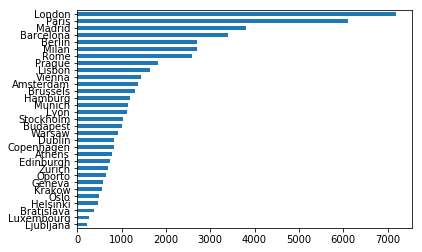

In [1303]:
data['City'].value_counts().sort_values(ascending=True).plot(kind='barh')

In [1304]:
# создадим новый признак, обозначающий, является ли город столицей
capital = ['Amsterdam', 'Athens', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin', 'Edinburgh', 'Helsinki',
           'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Madrid', 'Oslo', 'Paris', 'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw']
data['Capital'] = data['City'].apply(lambda x: 1 if x in capital else 0)

Есть идея создать признак, отражающий среднее к-во ресторанов на 1 тыс. человек в городе. Для этого добавим население по городу и к-во ресторанов по каждому городу:

In [1305]:
# Добавим признак населения по городу (в тыс.)
city_population = {'London': 10979, 'Paris': 11020, 'Madrid': 6026, 'Barcelona': 4588,
                   'Berlin': 6177, 'Milan': 4907, 'Rome': 3900, 'Prague': 1308,
                   'Lisbon': 2942, 'Vienna': 2300, 'Amsterdam': 2400, 'Brussels': 1831,
                   'Hamburg': 1841, 'Munich': 1471, 'Lyon': 1748, 'Stockholm': 2352,
                   'Budapest': 2965, 'Warsaw': 3100, 'Dublin': 1347,
                   'Copenhagen': 1308, 'Athens': 3168, 'Edinburgh': 513,
                   'Zurich': 1334, 'Oporto': 1313, 'Geneva': 496, 'Krakow': 1200,
                   'Oslo': 1558, 'Helsinki': 1299, 'Bratislava': 700,
                   'Luxembourg': 626, 'Ljubljana': 508}
data['Сity_population'] = data['City'].map(city_population)

In [1306]:
# добавим признак к-ва ресторанов в городе
restaurant_stat = {'Paris': 17593, 'Stockholm': 3131, 'London': 22366, 'Berlin': 8110, 'Munich': 3367,'Oporto': 2060,
    'Milan': 7940, 'Bratislava': 1331, 'Vienna': 4387, 'Rome': 12086, 'Barcelona': 10086, 'Madrid': 11562,
    'Dublin': 2706, 'Brussels': 3703, 'Zurich': 1901, 'Warsaw': 3210, 'Budapest': 3445, 'Copenhagen': 2637,
    'Amsterdam': 4189, 'Lyon': 2833, 'Hamburg': 3501, 'Lisbon': 4985, 'Prague': 5850, 'Oslo': 1441,
    'Helsinki': 1661, 'Edinburgh': 2248, 'Geneva': 1753, 'Ljubljana': 647, 'Athens': 2814,
    'Luxembourg': 759, 'Krakow': 1832}
data['Rest_count'] = data['City'].map(restaurant_stat)

In [1307]:
data['Rest_per_1k'] = data['Rest_count'] / data['Сity_population']

**Cuisine Style**

Попробуем проанализировать, какие типы кухонь самый популярныe:

In [1308]:
data_cuisine = data.copy()
data_cuisine = data_cuisine.explode('Cuisine_style')

Vegetarian Friendly - самая часто встречающаяся кухня среди предоставленных ресторанов. В то же время в датасете имеется 126 уникальных значений по признаку

In [1309]:
data_cuisine['Cuisine_style'].value_counts()

Vegetarian Friendly    14021
European               12561
Mediterranean           7820
Italian                 7433
Vegan Options           5684
                       ...  
Polynesian                 2
Salvadoran                 1
Burmese                    1
Xinjiang                   1
Latvian                    1
Name: Cuisine_style, Length: 126, dtype: int64

In [1310]:
data_cuisine['Cuisine_style'].nunique()

126

Посмотрим, сколько в среднем кухонь предоставленно в одном ресторане (если в данных пропуск - заменим по умолчанию единицей)

In [1311]:
data['Cuisine_count'] = data['Cuisine_style'].apply(lambda x: 1 if len(x)==0 else len(x))
data['Cuisine_count'].mean()

2.62586

Посмотрим, какое среднее к-во кухонь представлено в ресторанах каждого города

In [1312]:
avg_cusines_per_city = data.groupby('City')['Cuisine_count'].mean().sort_values(ascending=False)
print(avg_cusines_per_city)

City
Edinburgh     3.734228
Ljubljana     3.405405
Amsterdam     3.322157
Dublin        3.320574
Budapest      3.278159
Rome          3.195056
Krakow        3.138989
Oslo          3.086066
Zurich        3.010219
London        2.969971
Prague        2.854075
Vienna        2.742897
Luxembourg    2.741445
Oporto        2.721184
Copenhagen    2.705739
Barcelona     2.679234
Lisbon        2.656345
Helsinki      2.627368
Athens        2.613402
Geneva        2.600000
Warsaw        2.566486
Stockholm     2.512101
Brussels      2.503044
Milan         2.477728
Munich        2.459389
Berlin        2.277264
Bratislava    2.228947
Paris         2.144073
Madrid        2.106740
Hamburg       1.936762
Lyon          1.637655
Name: Cuisine_count, dtype: float64


In [1313]:
# создадим новый признак среднего к-ва кухонь в ресторане для каждого города
avg_cuisines_per_city_dict = avg_cusines_per_city.to_dict()
data['Avg_cuisine_count'] = data['City'].map(avg_cuisines_per_city_dict)

Посмотрим, какие 3 самые популярные кухни по каждому городу и создадим новый признак "Represents TOP cuisine" со значениями: 1 - если ресторан представляет хотя бы одну самую популярную кухню по городу и 0 - если нет

In [1314]:
#Выводим топ 3 самых популярных кухонь по городу, игнорируя пустые значения
cuisines_per_city = data_cuisine[data_cuisine['Cuisine_style'].notnull()].groupby(
    ['City','Cuisine_style']).agg({'Restaurant_id':'count'})
top_cuisines_per_city = cuisines_per_city['Restaurant_id'].groupby('City', group_keys=False).nlargest(3).reset_index()

#преобразование в словарь с ключами по городам и значениями - списком 3 самых популярных кухонь в городе
top_cuisines_per_city = top_cuisines_per_city[['City', 'Cuisine_style']]
top_cuisines_per_city = top_cuisines_per_city.groupby('City')['Cuisine_style'].apply(list).reset_index()
top_cuisines_dic = top_cuisines_per_city.set_index('City').to_dict()['Cuisine_style']

# добавляем список 3 популярных кухонь по городу в датасет
data['Top_cuisine'] = data['City'].map(top_cuisines_dic)


# функция на проверку пересечения списка кухонь ресторана со списком топ 3 самых популярных кухонь по городу
def intersect(x1, x2):
    x3 = [value for value in x1 if value in x2]
    if len(x3) >= 1:
        return 1
    else:
        return 0

    
data['Repr_TOP'] = data.apply(lambda row: intersect(row['Cuisine_style'], row['Top_cuisine']), 
                                 axis=1)

**Ranking**

Посмотрим на распределение признака

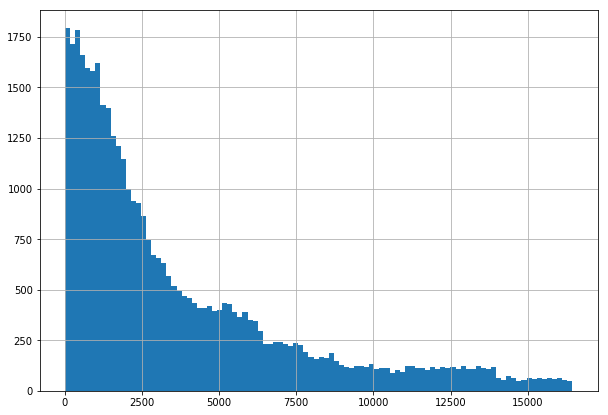

In [1315]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

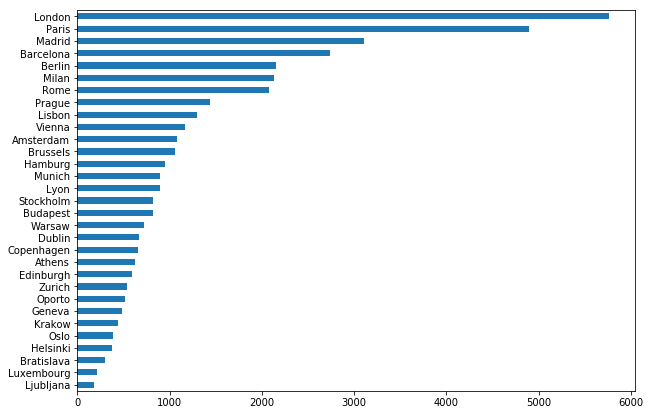

In [1316]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

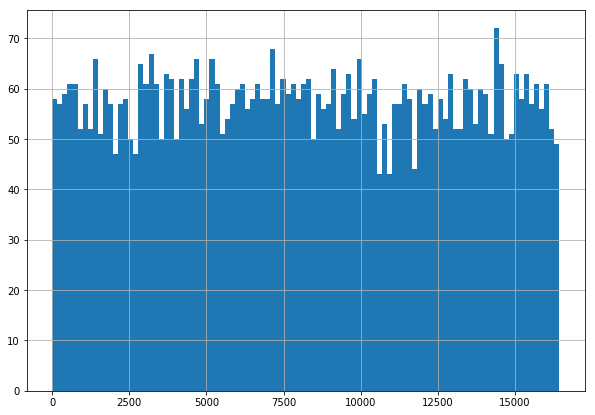

In [1317]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

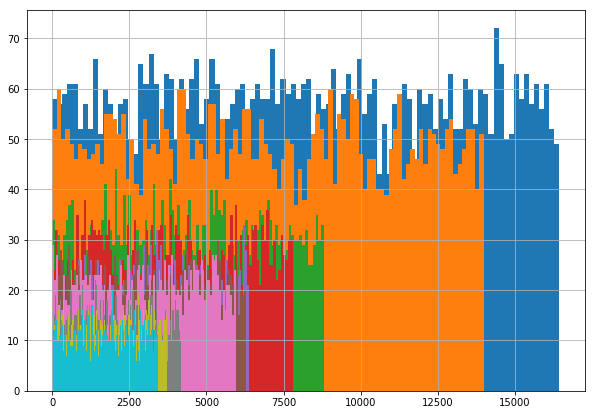

In [1318]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за этого мы этого имеем смещение.Следовательно, можно добавить признак среднего значения Ranking относительно к-ва ресторанов:

In [1319]:
# относительно к-ва ресторанов
data['Ranking_RestCount'] = data['Ranking'] / data['Rest_count']

In [1320]:
# относительно макс значения по городу
data['Ranking_max'] = data['Ranking'] / data['City'].map(data.groupby(['City'])['Ranking'].max())

In [1321]:
# признак отклонения по городу для каждого ресторана:
data['Ranking_Z'] = data.groupby('City')['Ranking'].transform(lambda x: stats.zscore(x,ddof=1)) 

**Price Range**

In [1322]:
data['Price_range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price_range, dtype: int64

In [1323]:
 #Заполним пустые значения самым частым
data['Price_range'] = data['Price_range'].fillna(data['Price_range'].value_counts().index[0])

По описанию 'Price Range' это - Цены в ресторане.
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3. Не буду создавать dummy переменные, так как проверено, что качество модели таким образом ухудшается

In [1324]:
price_dict = {'$': 0, '$$ - $$$': 1, '$$$$': 2}
data['Price_range'] = data['Price_range'].map(price_dict)

**Number of Reviews**

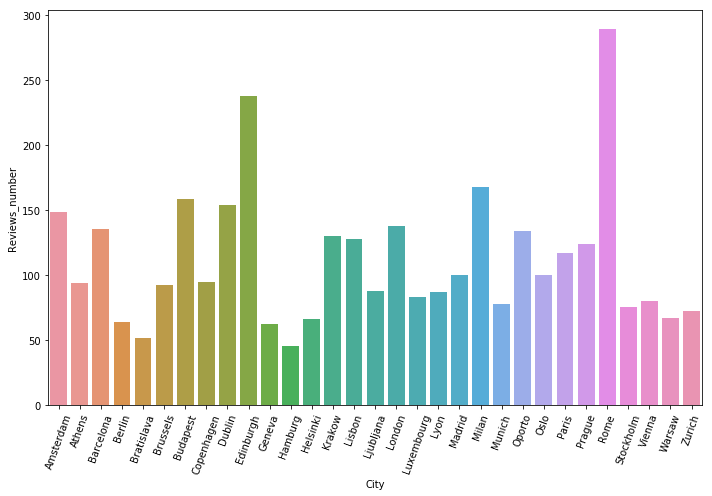

In [1325]:
# Посмотрим на среднее к-во отзывов по городам
average_reviews_per_city = data.groupby('City')['Reviews_number'].mean().reset_index()
sns.barplot(x = 'City', y = 'Reviews_number', data = average_reviews_per_city)
plt.xticks(rotation=70)
plt.tight_layout()

In [1326]:
# заполним пустые значения средним по городу
dict_reviews = data.groupby('City')['Reviews_number'].mean().to_dict()
data['Reviews_number'] = data['Reviews_number'].fillna(data['City'].map(dict_reviews))

In [1327]:
# посмотрим верхнюю границу выбросов по межквартильному расстоянию
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.quantile(ys, [0.25, 0.75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return upper_bound

outliers_iqr(data['Reviews_number'])

295.9443061605476

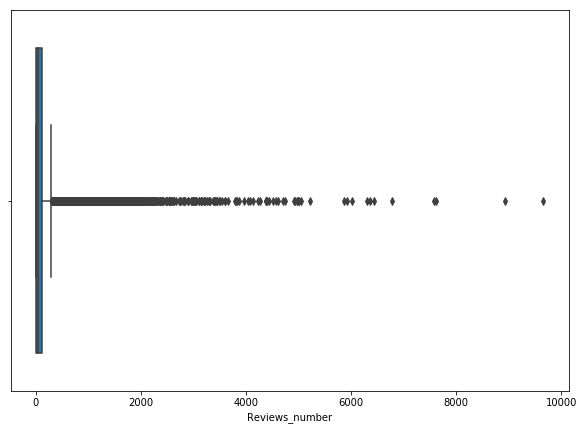

In [1328]:
sns.boxplot(data['Reviews_number'])

По боксплоту видно смещение вправо. Несмотря на верхнюю границу в 295, воспользуемся чисто визуальным восприятием и предположим, что к-во отзывов выше 5000 - это выбросы, так как они наибольше выбиваются из графика

In [1329]:
# установим верхнюю границу в 5000 и заменим все значения выше 
data['Reviews_number'] = data['Reviews_number'].apply(lambda x: 5000 if x > 5000 else x)

In [1330]:
# новый признак - к-во отзывов относительно населения города (1к)
data['Reviews_per_1k'] = data['Reviews_number'] / data['Сity_population']

**Review dates**

Попробуем разбить даты и посмотреть разницу между ними:

In [1331]:
def review_date(x, date='latest'):
    '''функция для отбора даты по значению'''
    if len(x) == 0:
        return 'NaN'
    elif len(x) == 1:
        return x[0]
    elif len(x) == 2:
        date_1 = x[0]
        date_2 = x[1]
        latest = max(date_1, date_2)
        earliest = min(date_1, date_2)
        if date == 'latest':
            return latest
        else:
            return earliest            
        
data['Latest_date'] = pd.to_datetime(data['Review_dates'].apply(lambda x: review_date(x,'latest')))
data['Earliest_date'] = pd.to_datetime(data['Review_dates'].apply(lambda x: review_date(x, date='earliest')))

In [1332]:
# создадим новую dummy переменную, указывающую на отсутствие отзывов в ресторане (== отсутствие дат)
data['Reviews_isNAN'] = pd.isna(data['Latest_date']).astype('uint8')

In [1333]:
# самый свежий отзыв
data['Latest_date'].max()

Timestamp('2018-02-26 00:00:00')

In [1334]:
# самый старый отзыв
data['Earliest_date'].min()

# им же заполним пробелы в данных
data['Earliest_date'] = data['Earliest_date'].fillna(data['Earliest_date'].min())
data['Latest_date'] = data['Latest_date'].fillna(data['Latest_date'].min())

In [1335]:
#посчитаем разницу между первым и последним отзывом и создадим соответствующий признак
data['Days_btw_reviews'] = data['Latest_date'] - data['Earliest_date']
data['Days_btw_reviews'] = data['Days_btw_reviews'].apply(lambda x: x.days)

In [1336]:
# посчитаем, сколько дней прошло с последнего отзыва и вынесем как новый признак
today = pd.to_datetime(date.today().strftime("%Y-%m-%d"))
data['Days_todate'] = data['Latest_date'].apply(lambda x: today - x)
data['Days_todate'] = data['Days_todate'].apply(lambda x: x.days)

**Reviews**

Попробуем проанализировать тональность отзывов, используя SentimentIntensityAnalyzer, который присваивает оценку от -1 до 1 для фрагмента текста, где -1 - негативное значение, а 1 - положительное. Для целого предложения, как в нашем случае, будет так же выведена общая оценка на основе всех слов

In [1337]:
# разобьем на отдельные отзывы для последующего анализа, заменяя пустые значения временным "No data"
data_reviews = data.copy()
data_reviews = data_reviews.explode('Reviews')
data_reviews.Reviews = data_reviews.Reviews.fillna('No data')

In [1338]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

data_reviews['Scores'] = data_reviews['Reviews'].apply(lambda x: sid.polarity_scores(x))

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [1339]:
# для значений без данных, заменяем оценку на 0, для всех остальных берем Compound (общую оценку) из получившегося словаря 
data_reviews['Compound_score'] = data_reviews.apply(lambda row: 0 if row['Reviews'] == 'No data' else row['Scores']['compound'], axis = 1)

# здесь же создадим новые параметры - длина отзыва и к-во слов в отзыве
data_reviews['Review_len'] = data_reviews['Reviews'].apply(lambda x: len(x.strip()))
data_reviews['Words_count'] = data_reviews['Reviews'].apply(lambda x: len(x.strip().split(' ')))

# сгруппируем обратно по ID TA, который больше всего похож на идентификатор ресторана, взяв при этом средние значения
grouped_reviews = data_reviews.groupby('ID_TA')[['Compound_score', 'Review_len', 'Words_count']].mean()

# объединяем с финальным общим датафреймом
data = pd.merge(data, grouped_reviews, how = 'left', on = 'ID_TA')


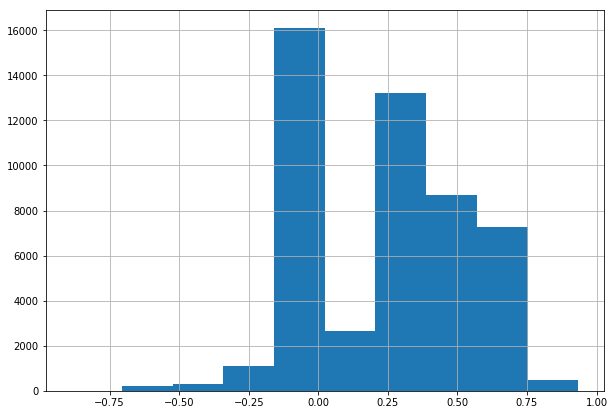

In [1340]:
# посмотрим на распределение Compound score:
data['Compound_score'].hist()

Исходя из распределения, будет достаточно справедливо считать, что отзывы с Compound score выше 0.3 - позитивные, 0 и < 0.3 - нейтральные (или нету отзыва), а ниже 0 - негативные (к тому же данное определение дает наилучший показатель MAE в сравнении с другими протестированными). Создадим на основе данной логики новый параметр Tone:

In [1341]:
def tone(x):
    '''функция на опредение тональности отзыва исходя из Compound Score'''
    if x < 0:
        return 0
    if 0 <= x < 0.3:
        return 1
    if x >= 0.3:
        return 2

    
data['Tone'] = data['Compound_score'].apply(lambda x: tone(x))

**ID_TA**

ID_TA значения тоже повторяются. При более детальном просмотре видно, что это все же одни и те же рестораны, но с разными показателями Ranking. Удялить их все равно нельзя, зато можно попробовать создать параметр, указывающий на то, что такой ID_TA уже есть

In [1342]:
data['ID_TA'].value_counts()

d1028622     2
d13002276    2
d5618007     2
d3685055     2
d7809594     2
            ..
d1832198     1
d2186593     1
d3675014     1
d7398572     1
d7298618     1
Name: ID_TA, Length: 49963, dtype: int64

In [1343]:
data[data['ID_TA'] == 'd1028622']

,Restaurant_id,City,Cuisine_style,Ranking,Price_range,Reviews_number,Reviews,URL_TA,ID_TA,sample,...,Ranking_Z,Reviews_per_1k,Latest_date,Earliest_date,Days_btw_reviews,Days_todate,Compound_score,Review_len,Words_count,Tone
4534,4534,Madrid,"[Bar, European, Spanish, Delicatessen]",1253.0,2,116.0,"['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,0,...,-1.240484,0.01925,2017-10-31,2017-06-27,126,1310,0.0,36.0,6.5,1
28388,1229,Madrid,"[Bar, European, Spanish, Delicatessen]",1231.0,2,116.0,"['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,1,...,-1.249187,0.01925,2017-10-31,2017-06-27,126,1310,0.0,36.0,6.5,1


при удалении признака, MAE становится хуже, поэтому оставляем в числовом формате

In [1344]:
data['ID_TA'] = data['ID_TA'].apply(lambda x: int(x[1:]))

### Посмотрим распределение целевой переменной

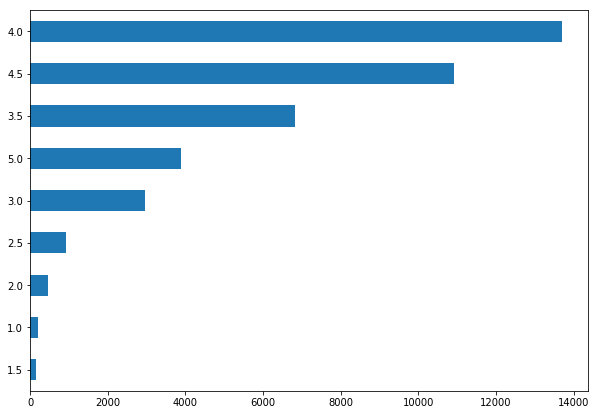

In [1345]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

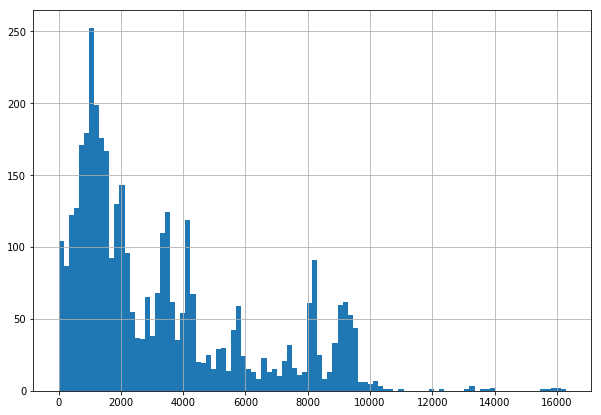

In [1346]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

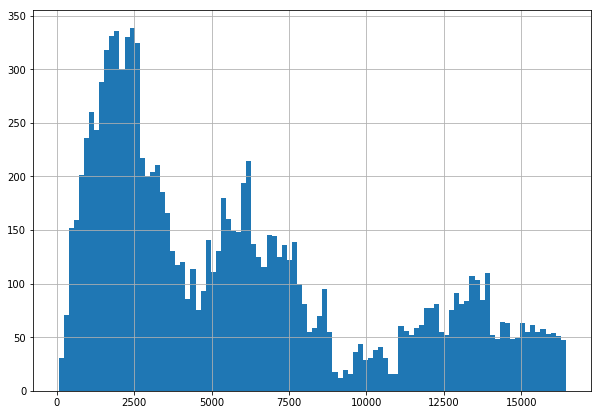

In [1347]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

Среднее значения рейтинга по городу не сильно отличается

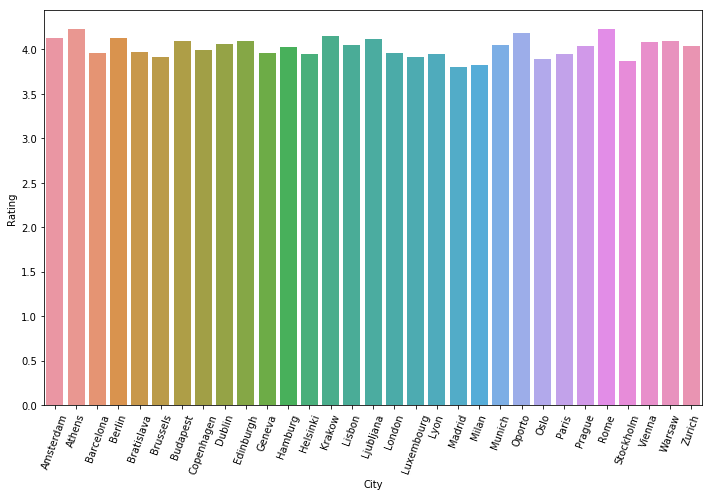

In [1348]:
sns.barplot(x = 'City', y = 'Rating', data = df_train.groupby('City').Rating.mean().reset_index())
plt.xticks(rotation=70)
plt.tight_layout()

### Корреляция признаков
На этом графике заметно, что некоторые признаки достаточно скоррелированы между собой. Сильных корреляций с предсказываемой переменной обнаружено не было:

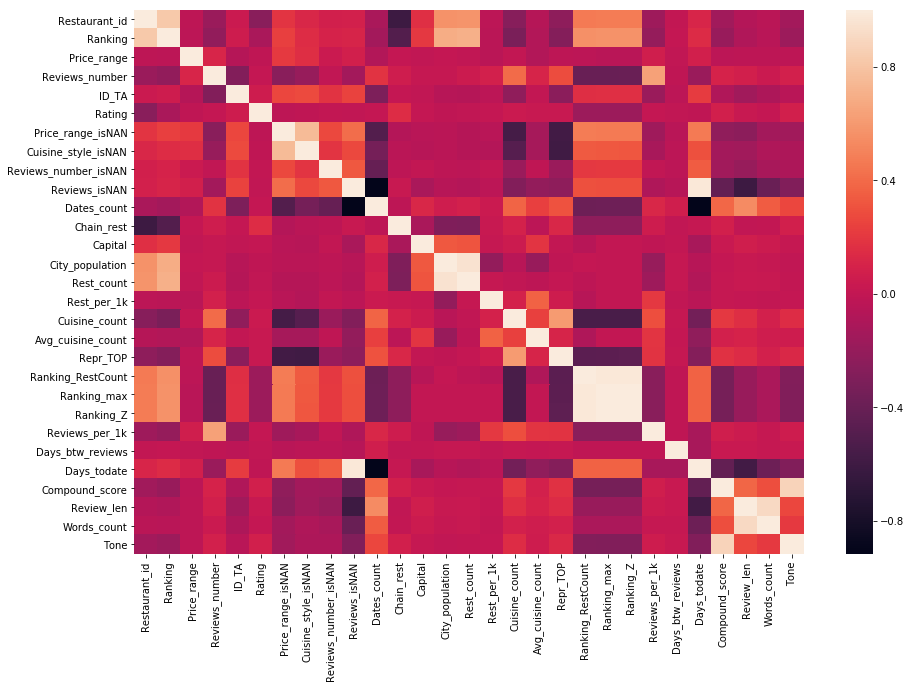

In [1349]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Поскольку скоррелированных признаков много - выведем пары с корреляцией |0.75| и выше в виде таблицы. Полученные пары достаточно очевидны, так как это признаки, которые либо были созданы на основе друг друга, либо отражают похожую информацию

In [1350]:
# выведем в виде таблицы самые скоррелированные признаки (+/-)
abs_corr = data.drop(['sample'], axis=1).corr().abs()

abs_corr = abs_corr.stack().reset_index()
abs_corr.columns = ['Feature_1','Feature_2','Corr']
mask_dups = (abs_corr[['Feature_1', 'Feature_2']].apply(frozenset, axis=1).duplicated()) | (abs_corr['Feature_1']==abs_corr['Feature_2']) 
abs_corr = abs_corr[~mask_dups]
filt_corr = abs_corr[abs_corr['Corr'] > 0.75]
print(filt_corr)

# выведем все из Feature_1 в отдельный список, чтобы удалить:
abs_corr_list = filt_corr['Feature_1'].tolist()

             Feature_1            Feature_2      Corr
1        Restaurant_id              Ranking  0.825090
181  Price_range_isNAN  Cuisine_style_isNAN  0.753183
271      Reviews_isNAN          Dates_count  0.909918
285      Reviews_isNAN          Days_todate  0.977776
314        Dates_count          Days_todate  0.916285
391    Сity_population           Rest_count  0.953822
571  Ranking_RestCount          Ranking_max  0.980015
572  Ranking_RestCount            Ranking_Z  0.979921
601        Ranking_max            Ranking_Z  0.999784
753     Compound_score                 Tone  0.876713
781         Review_len          Words_count  0.908872


Как показала практика, удаление данных признаков, вопреки ожиданиям, сильно ухудшает MAE (с 16.18 до 16.46). Поэтому было принято решение их оставить. 

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [1351]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    # ################### 1. Предобработка ############################################################## 
    df_output = df_input.copy()
    df_output = df_output.drop(['Latest_date', 'Earliest_date'], axis = 1)
    #df_output = df_output.drop(abs_corr_list, axis = 1)  # не удаляем признаки, так как МАЕ ухудшается
        
    # ################### 2. Encoding ############################################################## 
    df_output = pd.get_dummies(df_output, columns=['City'], dummy_na=True) 
    
    # ################### 3. Clean #################################################### 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output


#### Запускаем и проверяем что получилось

In [1352]:
df_preproc = preproc_data(data)
df_preproc.sample(10)
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 62 columns):
Restaurant_id           50000 non-null int64
Ranking                 50000 non-null float64
Price_range             50000 non-null int64
Reviews_number          50000 non-null float64
ID_TA                   50000 non-null int64
sample                  50000 non-null int64
Rating                  50000 non-null float64
Price_range_isNAN       50000 non-null uint8
Cuisine_style_isNAN     50000 non-null uint8
Reviews_number_isNAN    50000 non-null uint8
Reviews_isNAN           50000 non-null uint8
Dates_count             50000 non-null int64
Chain_rest              50000 non-null int64
Capital                 50000 non-null int64
Сity_population         50000 non-null int64
Rest_count              50000 non-null int64
Rest_per_1k             50000 non-null float64
Cuisine_count           50000 non-null int64
Avg_cuisine_count       50000 non-null float64
Repr_TOP                50

In [1353]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [1354]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [1355]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 61), (40000, 61), (40000, 60), (32000, 60), (8000, 60))

# Model 
Сам ML

In [1356]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [1357]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [1358]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [1359]:
# округляем 
y_pred = np.round(y_pred * 2) / 2

In [1360]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1616875


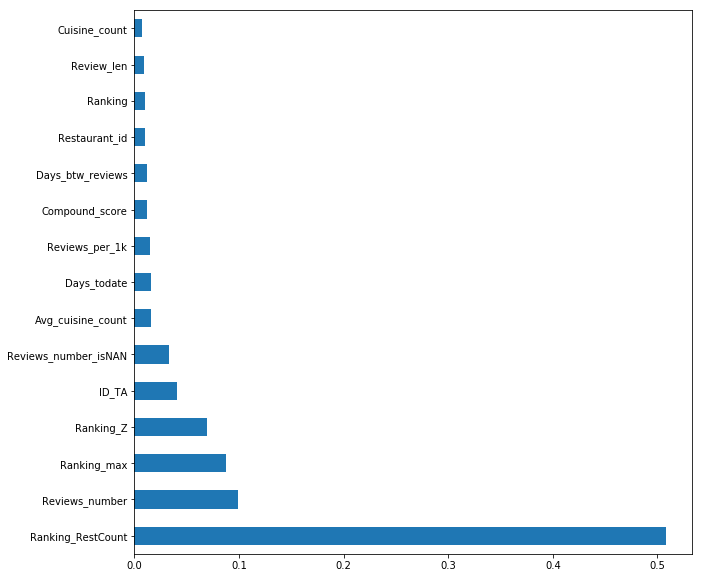

In [1361]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [1362]:
test_data.sample(10)

,Restaurant_id,Ranking,Price_range,Reviews_number,ID_TA,Rating,Price_range_isNAN,Cuisine_style_isNAN,Reviews_number_isNAN,Reviews_isNAN,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
634,634,735.0,1,21.0,7603746,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1547,1547,1399.0,1,14.0,10779831,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7026,7026,1937.0,1,277.0,3916918,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9722,9722,9041.0,1,13.0,4153196,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2863,2863,1622.0,1,25.0,8773444,0.0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3154,3154,66.0,1,1426.0,7656645,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9319,9319,3859.0,1,12.0,2160806,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2816,2816,3186.0,1,2.0,12202205,0.0,1,1,0,1,...,0,0,0,0,0,0,1,0,0,0
3666,3666,8132.0,1,5.0,8730782,0.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3595,3595,13960.0,1,23.0,7686556,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1363]:
test_data = test_data.drop(['Rating'], axis=1)

In [1364]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [1365]:
predict_submission = model.predict(test_data)
predict_submission = np.round(predict_submission * 2) / 2

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [1366]:
predict_submission

array([3.5, 4. , 4.5, ..., 3. , 4.5, 4. ])

In [1367]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.5
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5
